In [ ]:
!pip install pyspark
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=83c26af630b8035d124b73dac690d2fd319b0bd6177125895e7c9f19cc253cc0
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


##Task 1##

Number of CPUs used by SparkContext: 2


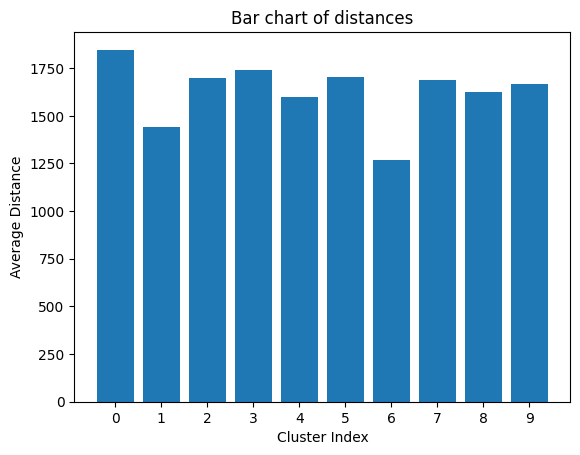

In [ ]:
import findspark
findspark.init()

import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pyspark.sql.functions as F
from pyspark import SparkContext
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import col, lit, udf, when, avg
from pyspark.sql.types import IntegerType, FloatType, StructField, StructType
from pyspark.ml.linalg import DenseVector, Vectors, VectorUDT
from pyspark.ml.clustering import KMeans

# Create a SparkSession
spark: SparkSession = SparkSession.builder.appName("KMeansClustering").getOrCreate()

# Get the SparkContext from the SparkSession
sc: SparkContext = spark.sparkContext

print(f"Number of CPUs used by SparkContext: {sc.defaultParallelism}")

# Define UDFs
def parse_line(line: str) -> tuple[int, DenseVector]:
    sample = line.strip().split(",")
    label = int(sample[0])
    digit = Vectors.dense([float(x) for x in sample[1:]])
    return label, digit

parse_line_udf = udf(
    parse_line,
    StructType([
        StructField("label", IntegerType(), False),
        StructField("coord", VectorUDT(), False),
    ])
)

def dist_from_center(point: DenseVector, cluster: int, centers: list[np.ndarray]) -> float:
    return float(np.linalg.norm(point - centers[cluster]))

# Helper class for plotting
class Plotting:
    @staticmethod
    def plot_distances(distances: dict[int, float]):
        plt.close()
        plt.figure()
        indices = list(distances.keys())
        distance_values = list(distances.values())

        plt.bar(indices, distance_values)
        plt.xlabel("Cluster Index")
        plt.ylabel("Average Distance")
        plt.title("Bar chart of distances")
        plt.xticks(range(min(indices), max(indices) + 1))
        plt.show()

# KMeans clustering class
class KMean:
    COL_IDX = "idx"
    COL_COORD = "coord"
    COL_WEIGHT = "weight"
    COL_CLUSTER = "cluster"
    COL_DIST = "dist"
    COL_AVG_DIST = "avg_dist"

    INIT_RAND = "random"
    INIT_PP = "k-means||"

    def __init__(self, df: DataFrame, k: int, max_iter: int, converge_dist: float, seed: int, special_indices: list[int], init_rand=True, df_count: int = None, init_step=2):
        self.df = df
        self.k = k
        self.max_iter = max_iter
        self.converge_dist = converge_dist
        self.seed = seed
        self.special_indices = special_indices
        self.init_rand = init_rand
        self.count = df_count if df_count is not None else self.df.count()
        self.init_step = init_step
        self.cluster_centers = None
        self.k_mean_obj = None
        self.k_mean_model = None

    def init_mode(self, init_rand=False) -> str:
        return self.INIT_RAND if init_rand else self.INIT_PP

    def create_spark_model(self, seed: int = None, init_rand: bool = None) -> KMeans:
        seed = seed if seed is not None else self.seed
        init_rand = init_rand if init_rand is not None else self.init_rand
        self.k_mean_obj = KMeans(
            featuresCol=self.COL_COORD,
            predictionCol=self.COL_CLUSTER,
            k=self.k,
            initMode=self.init_mode(init_rand),
            initSteps=self.init_step,
            tol=self.converge_dist,
            maxIter=self.max_iter,
            seed=seed,
            weightCol=self.COL_WEIGHT,
        )
        return self.k_mean_obj

    def run(self, k_mean_obj: KMeans, df: DataFrame) -> DataFrame:
        self.k_mean_model = k_mean_obj.fit(df)
        self.cluster_centers = self.k_mean_model.clusterCenters()
        predict_df = self.k_mean_model.transform(df)
        predict_df = predict_df.select(self.COL_IDX, self.COL_COORD, self.COL_CLUSTER)
        return predict_df

    def calculate_distance_centers(self, predict_df: DataFrame) -> dict[int, float]:
        sc_cluster_centers = sc.broadcast(self.cluster_centers)
        fn_dist = udf(lambda coord, idx: dist_from_center(coord, idx, sc_cluster_centers.value), FloatType())
        dist_df = predict_df.withColumn(self.COL_DIST, fn_dist(col(self.COL_COORD), col(self.COL_CLUSTER)))
        dist_df = dist_df.select(self.COL_CLUSTER, self.COL_DIST)
        dist_avg_df = dist_df.groupBy(self.COL_CLUSTER).agg(avg(self.COL_DIST).alias(self.COL_AVG_DIST))
        dist_agg_collect = dist_avg_df.collect()
        sc_cluster_centers.destroy()
        distances = {row[self.COL_CLUSTER]: row[self.COL_AVG_DIST] for row in dist_agg_collect}
        return distances

    @classmethod
    def read_from_csv(cls, filepath: str, special_indices: list[int], special_weight_mult: float, init_rand: bool, k=10, max_iter=20, converge_dist=0.0001, seed=1, default_weight=1.0, init_step=2) -> "KMean":
        if not os.path.isfile(filepath):
            raise FileNotFoundError(f"Could not find file at: {filepath}")

        df = spark.read.csv(filepath, header=False, inferSchema=True)
        df = df.withColumn("parsed", parse_line_udf(F.concat_ws(",", *df.columns)))
        df = df.select(F.monotonically_increasing_id().alias(cls.COL_IDX), "parsed.label", "parsed.coord")
        df = df.withColumn(cls.COL_WEIGHT, when(col(cls.COL_IDX).isin(special_indices), lit(special_weight_mult * default_weight)).otherwise(lit(default_weight)))
        df_count = df.count()
        return KMean(df, k, max_iter, converge_dist, seed, special_indices, init_rand, df_count, init_step)

# Replace `file_path` with the actual path to mnist_mini.csv
file_path = "mnist_mini.csv"

mnist_kmean = KMean.read_from_csv(
    file_path,
    special_indices=[0, 1, 2, 3, 4, 7, 8, 11, 18, 61],
    special_weight_mult=100.0,
    init_rand=False,
    k=10,
    max_iter=20,
    converge_dist=0.0001,
    seed=1,
    default_weight=1.0,
    init_step=2,
)

mnist_kmean.create_spark_model()

predict_df = mnist_kmean.run(mnist_kmean.k_mean_obj, mnist_kmean.df)

distances = mnist_kmean.calculate_distance_centers(predict_df)

Plotting.plot_distances(distances)


##Task 2##

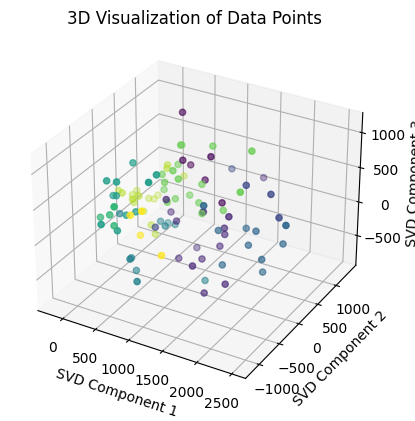

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random

class DimensionalityReduction:
    def __init__(self, df: DataFrame, k: int):
        self.df = df
        self.k = k
        self.pca_model = None

    def apply_svd(self) -> DataFrame:
        pca = PCA(k=self.k, inputCol="coord", outputCol="pca_features")
        self.pca_model = pca.fit(self.df)
        result_df = self.pca_model.transform(self.df)
        return result_df

class Visualization:
    @staticmethod
    def random_sample(df: DataFrame, sample_size: int, seed: int = None) -> DataFrame:
        return df.sample(withReplacement=False, fraction=float(sample_size) / df.count(), seed=seed)

    @staticmethod
    def plot_3d(data: list[tuple[float, float, float]], labels: list[int]):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xs = [x for x, y, z in data]
        ys = [y for x, y, z in data]
        zs = [z for x, y, z in data]
        ax.scatter(xs, ys, zs, c=labels, cmap='viridis', marker='o')

        ax.set_xlabel('SVD Component 1')
        ax.set_ylabel('SVD Component 2')
        ax.set_zlabel('SVD Component 3')

        plt.title("3D Visualization of Data Points")
        plt.show()
# Load the dataset
file_path = "mnist_mini.csv"
mnist_kmean = KMean.read_from_csv(
    file_path,
    special_indices=[0, 1, 2, 3, 4, 7, 8, 11, 18, 61],
    special_weight_mult=100.0,
    init_rand=False,
    k=10,
    max_iter=20,
    converge_dist=0.0001,
    seed=1,
    default_weight=1.0,
    init_step=2,
)

# Apply k-means clustering
mnist_kmean.create_spark_model()
predict_df = mnist_kmean.run(mnist_kmean.k_mean_obj, mnist_kmean.df)

# Reduce dimensionality using SVD
dim_reduction = DimensionalityReduction(predict_df, k=3)
reduced_df = dim_reduction.apply_svd()

# Randomly select 100 data points
sample_df = Visualization.random_sample(reduced_df, 100, seed=1)
sample_data = sample_df.select("pca_features", "cluster").collect()

# Prepare data for plotting
plot_data = [(row['pca_features'][0], row['pca_features'][1], row['pca_features'][2]) for row in sample_data]
labels = [row['cluster'] for row in sample_data]

# Plot the data
Visualization.plot_3d(plot_data, labels)


##Task 3##

Model with rank: 10, MSE: 0.10660847082461233
Model with rank: 11, MSE: 0.10273034220537691
Model with rank: 12, MSE: 0.09331981547038229
Model with rank: 13, MSE: 0.09203664185775376
Model with rank: 14, MSE: 0.09001610826034105
Model with rank: 15, MSE: 0.08707558976730993
Model with rank: 16, MSE: 0.08647519520709437
Model with rank: 17, MSE: 0.08461297277860454
Model with rank: 18, MSE: 0.08472048515987159
Model with rank: 19, MSE: 0.08386163836640116
Model with rank: 20, MSE: 0.08366979467620499


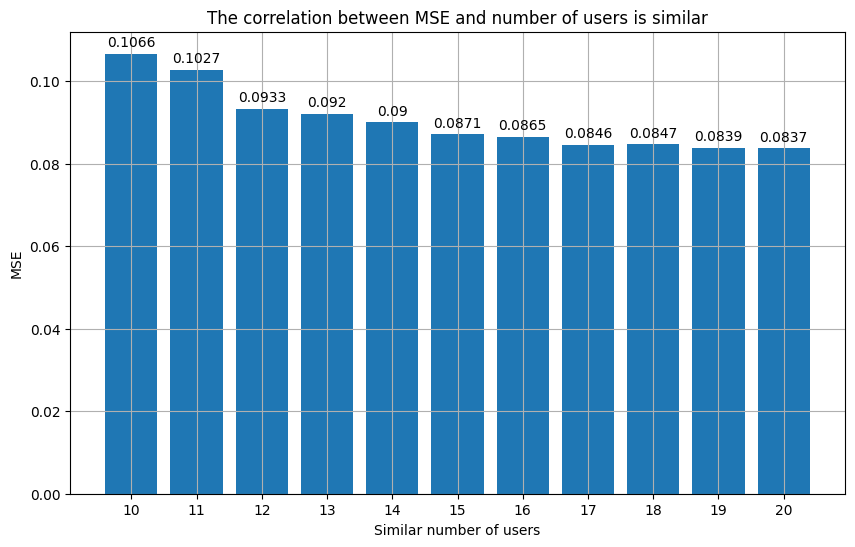

User ID: 1, Movie ID: 10, Predicted Rating: 3.9900882244110107
User ID: 1, Movie ID: 11, Predicted Rating: 3.16921067237854
User ID: 1, Movie ID: 12, Predicted Rating: 4.005319118499756
User ID: 1, Movie ID: 13, Predicted Rating: 2.619896173477173
User ID: 1, Movie ID: 14, Predicted Rating: 0.8030766844749451
User ID: 1, Movie ID: 15, Predicted Rating: 3.007214069366455
User ID: 1, Movie ID: 16, Predicted Rating: 2.8656015396118164
User ID: 1, Movie ID: 17, Predicted Rating: 2.542710065841675
User ID: 1, Movie ID: 18, Predicted Rating: 3.578413963317871
User ID: 1, Movie ID: 19, Predicted Rating: 2.1137728691101074
User ID: 1, Movie ID: 20, Predicted Rating: 2.395961284637451


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

class MovieRecommender:
    def __init__(self, spark, data_path):
        self.spark = spark
        self.data_path = data_path
        self.data = None
        self.model = None

    def load_data(self):
        self.data = self.spark.read.csv(self.data_path, header=True, inferSchema=True)

    def split_data(self, train_ratio=0.7):
        train_data, test_data = self.data.randomSplit([train_ratio, 1 - train_ratio])
        return train_data, test_data

    def train_model(self, ranks):
        best_model = None
        best_mse = float('inf')
        userCol = "user"
        itemCol = "item"
        ratingCol = "rating"
        mse_values = []
        similar_users = []
        for rank in ranks:
            als = ALS(rank=rank, userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
            model = als.fit(self.data)

            predictions = model.transform(self.data)
            evaluator = RegressionEvaluator(metricName="mse", labelCol=ratingCol, predictionCol="prediction")
            mse = evaluator.evaluate(predictions)

            print(f"Model with rank: {rank}, MSE: {mse}")
            mse_values.append(mse)
            similar_users.append(rank)
            if mse < best_mse:
               best_model = model
               best_mse = mse
        self.model = best_model
        return mse_values, similar_users

    def predict(self, user_id, movie_id):
        if self.model:
            userCol = "user"
            itemCol = "item"
            prediction = self.model.transform(self.spark.createDataFrame([(user_id, movie_id)], [userCol, itemCol]))
            return prediction.select("prediction").collect()[0].prediction
        else:
            print("The model has not been trained.")

    def predict_for_movies(self, user_id, movie_ids):
        predictions = []
        for movie_id in movie_ids:
            prediction = self.predict(user_id, movie_id)
            predictions.append((user_id, movie_id, prediction))
        return predictions

def plot_mse_vs_similar_users(mse_values, similar_users):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(similar_users, mse_values)
    plt.xlabel("Similar number of users")
    plt.ylabel("MSE")
    plt.title("The correlation between MSE and number of users is similar")
    plt.xticks(similar_users)
    plt.grid(True)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + .001, round(yval, 4), ha='center', va='bottom')

    plt.show()

spark = SparkSession.builder.appName("MovieRecommender").getOrCreate()

recommender = MovieRecommender(spark,"/content/ratings2k.csv")

recommender.load_data()

train_data, test_data = recommender.split_data()

ranks_to_test = range(10, 21)
mse_values, similar_users = recommender.train_model(ranks_to_test)

plot_mse_vs_similar_users(mse_values, similar_users)

user_id = 1
movie_ids_to_predict = range(10, 21)
predictions = recommender.predict_for_movies(user_id, movie_ids_to_predict)

for user_id, movie_id, prediction in predictions:
    print(f"User ID: {user_id}, Movie ID: {movie_id}, Predicted Rating: {prediction}")

spark.stop()

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

import pyspark
print(pyspark.__version__)

3.1.1


Train MSE = 0.0005061831886882922
Test  MSE = 0.0007279145232441492
+----------+-----+--------------------+--------------------+--------------------+
|       day|price|         fluctuation|             feature|          prediction|
+----------+-----+--------------------+--------------------+--------------------+
|2022-06-01| 18.6|-0.00268092429400...|[-0.0261096610945...|-0.00346097905598...|
|2022-06-02| 18.0|-0.03225808436366903|[-0.0026809242940...|0.007807264785168893|
|2022-06-03|18.05|0.002777735392252604|[-0.0322580843636...|0.005587474246877699|
|2022-06-06| 17.9|-0.00831022852468...|[0.00277773539225...|0.002188247507709643|
|2022-06-07|17.65|-0.01396648074456...|[-0.0083102285246...|-0.00413692256884...|
|2022-06-08|18.05| 0.02266286839521086|[-0.0139664807445...|-0.00332126417484...|
|2022-06-09| 18.5| 0.02493079124432894|[0.02266286839521...|-0.00254118544792...|
|2022-06-10| 18.0|-0.02702702702702703|[0.02493079124432...|-0.00843699669488964|
|2022-06-13| 17.1|-0.049999978

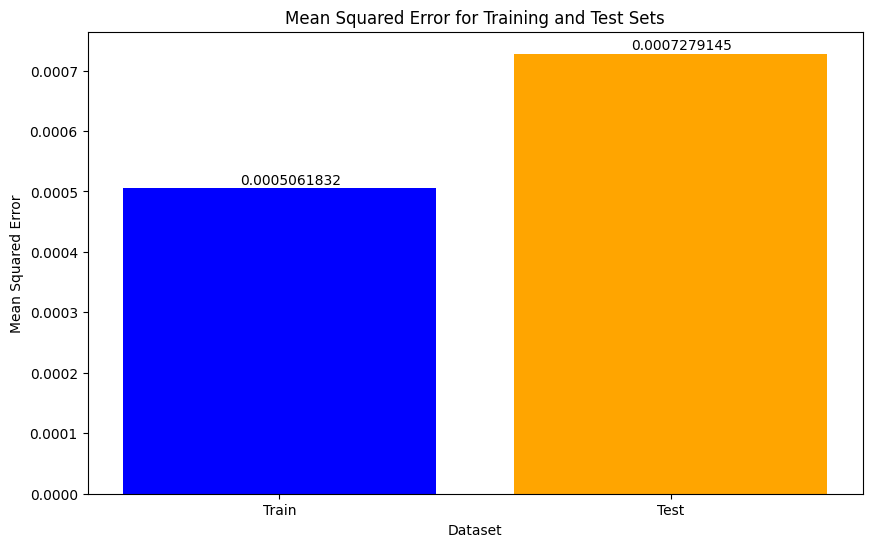

In [ ]:
import os
import findspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, array, expr, udf
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType, StructField, StructType, DateType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import DenseVector, VectorUDT
import matplotlib.pyplot as plt


# Create a SparkSession
spark  = SparkSession.builder.appName("StockPricePrediction").getOrCreate()

# Function to convert column to DenseVector
def fn_to_dense(c):
    return DenseVector(c)

# Registering the UDF
fn_to_dense_udf = udf(fn_to_dense, VectorUDT())

class StockLR:
    def __init__(self, df, df_count, k_window, train_df, test_df):
        self.df = df
        self.df_count = df_count
        self.k_window = k_window
        self.train_df = train_df
        self.test_df = test_df
        self.evaluator = RegressionEvaluator(
            predictionCol="prediction", labelCol="fluctuation", metricName="mse"
        )
        self.stock_models = dict()

    def fit(self, df, loss):
        """

        Args:
          df:
          loss:

        Returns:

        """
        stock_lr = LinearRegression(
            featuresCol="feature",
            labelCol="fluctuation",
            predictionCol="prediction",
            maxIter=100,
            regParam=0.3,
            loss=loss,
        )
        stock_model = stock_lr.fit(df)
        self.stock_models[loss] = stock_model
        return stock_model

    def eval_mse(self, model, df):
        pred_stock = model.transform(df)
        mse = self.evaluator.evaluate(pred_stock)
        return pred_stock, mse

    @classmethod
    def read_from_txt(
        cls,
        filepath,
        k_window,
        train_cond,
        test_cond,
        date_format="dd/MM/yyyy",
    ):
        if not os.path.isfile(filepath):
            raise FileNotFoundError(f"Could not find file at: {filepath}")

        df = spark.read.csv(
            filepath,
            header=True,
            dateFormat=date_format,
            schema=StructType(
                [
                    StructField("day", DateType(), True),
                    StructField("price", FloatType(), True),
                ]
            ),
        )

        df_count = df.count()

        window = Window.partitionBy().orderBy("day")

        df = df.withColumn(
            "fluctuation",
            (col("price") - lag(col("price"), 1).over(window))
            / lag(col("price"), 1).over(window),
        )
        df = df.na.fill(0.0, subset=["fluctuation"])

        w = Window.orderBy(df["day"])
        lagged_cols = [lag("fluctuation", i).over(w) for i in range(1, k_window)]

        df = df.withColumn("feature", array(*lagged_cols)).filter(
            ~expr("exists(filter(feature, x -> x is null), true)")
        )

        df = df.withColumn("feature", fn_to_dense_udf("feature"))

        train_df = df.filter(train_cond)
        test_df = df.filter(test_cond)

        return StockLR(
            df=df,
            df_count=df_count,
            k_window=k_window,
            train_df=train_df,
            test_df=test_df,
        )

def main():
    file_path = "stockHVN2022.csv"

    stocker = StockLR.read_from_txt(
        file_path,
        k_window=6,
        train_cond="day < date'2022-06-01'",
        test_cond="day > date'2022-05-31'",
    )

    stock_lr_model = stocker.fit(stocker.train_df, "huber")

    train_pred, train_mse = stocker.eval_mse(
        stocker.stock_models["huber"], stocker.train_df
    )
    test_pred, test_mse = stocker.eval_mse(
        stocker.stock_models["huber"], stocker.test_df
    )

    print(f"Train MSE = {train_mse}")
    print(f"Test  MSE = {test_mse}")

    # Show the prediction results
    test_pred.select("day", "price", "fluctuation", "feature", "prediction").show()

    data = [train_mse, test_mse]
    labels = ["Train", "Test"]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, data, color=['blue', 'orange'])

    for i, v in enumerate(data):
        plt.text(i - 0.1, v * 1.01, f"{v:.10f}", color="black")

    plt.xlabel('Dataset')
    plt.ylabel('Mean Squared Error')
    plt.title("Mean Squared Error for Training and Test Sets")
    plt.show()

    spark.stop()

if __name__ == "__main__":
    main()


##Task 5##

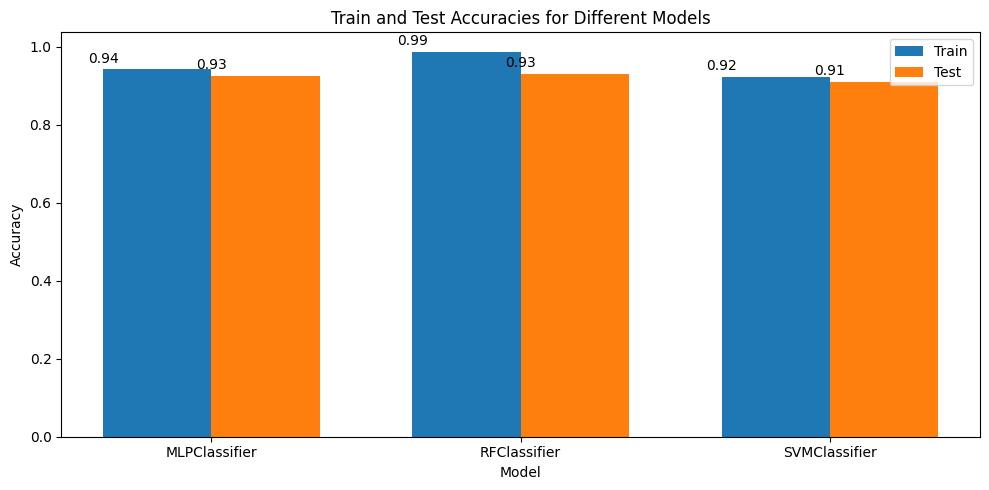

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier as PySparkMLP, RandomForestClassifier as PySparkRF, LinearSVC as PySparkSVM, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

class BaseClassifier:
    def __init__(self, spark, filepath):
        self.spark = spark
        self.filepath = filepath
        self.model = None
        self.data = None
        self.trained_model = None
        self.train_data = None
        self.test_data = None

    def load_data(self):
        # Load and automatically infer the input schema (csv file)
        self.data = self.spark.read.csv(self.filepath, header=False, inferSchema=True)
        # Assemble vectors (features)
        assembler = VectorAssembler(inputCols=self.data.columns[1:], outputCol="features")
        self.data = assembler.transform(self.data).selectExpr("_c0 as label", "features")
        # Split the data into train and test sets
        self.train_data, self.test_data = self.data.randomSplit([0.8, 0.2], seed=1234)

    def fit(self):
        if self.model:
            self.trained_model = self.model.fit(self.train_data)

    def evaluate(self):
        evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
        predictions_train = self.trained_model.transform(self.train_data)
        predictions_test = self.trained_model.transform(self.test_data)
        train_accuracy = evaluator.evaluate(predictions_train)
        test_accuracy = evaluator.evaluate(predictions_test)
        return train_accuracy, test_accuracy

class MLPClassifier(BaseClassifier):
    def __init__(self, spark, filepath):
        super().__init__(spark, filepath)
        # Define the layers for the MLP
        layers = [784, 128, 64, 10]
        self.model = PySparkMLP(layers=layers, blockSize=128, seed=1234, maxIter=100)

class RFClassifier(BaseClassifier):
    def __init__(self, spark, filepath):
        super().__init__(spark, filepath)
        self.model = PySparkRF(numTrees=20, maxDepth=10, labelCol="label", featuresCol="features", seed=1234)

class SVMClassifier(BaseClassifier):
    def __init__(self, spark, filepath):
        super().__init__(spark, filepath)
        # Initialize the base classifier
        lsvc = PySparkSVM(maxIter=100, regParam=0.1)
        # Wrap LinearSVC in OneVsRest for multi-class classification
        self.model = OneVsRest(classifier=lsvc)

# Initialize Spark session
spark = SparkSession.builder.appName("MNIST Classification").getOrCreate()

# Path to the MNIST dataset
filepath = "/content/mnist_mini.csv"

# Initialize classifiers
mlp = MLPClassifier(spark, filepath)
rf = RFClassifier(spark, filepath)
svm = SVMClassifier(spark, filepath)

# List to hold classifiers for iteration
classifiers = [mlp, rf, svm]
results = {}

# Process each classifier
for classifier in classifiers:
    classifier_name = type(classifier).__name__
    classifier.load_data()
    classifier.fit()
    train_accuracy, test_accuracy = classifier.evaluate()
    results[classifier_name] = (train_accuracy, test_accuracy)

# Plotting results
fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.35
index = range(len(results))

train_accuracies = [results[model][0] for model in results]
test_accuracies = [results[model][1] for model in results]

bar1 = plt.bar(index, train_accuracies, bar_width, label='Train')
bar2 = plt.bar([i + bar_width for i in index], test_accuracies, bar_width, label='Test')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies for Different Models')
plt.xticks([i + bar_width / 2 for i in index], list(results.keys()))
plt.legend()

# Add accuracy values on top of bars
for i, v in enumerate(train_accuracies):
    plt.text(i - bar_width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(test_accuracies):
    plt.text(i + bar_width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
